# DMIA sport intro: How frequent is this password?

### Belov Vitaly

https://www.kaggle.com/c/dmia-sport-2019-fall-intro/overview

In [3]:
import pandas as pd
import numpy as np

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import re

import math

### 1. Data preparation  

In [4]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('Xtest.csv')
print(train_data.shape)
print(test_data.shape)

(4151496, 2)
(1037875, 2)


#### 1.1 Train

In [5]:
train_data.dropna(inplace=True)

In [6]:
#train data sample
train_data.sort_values(by='Times', ascending=False).head()

,Password,Times
2715397,123456,55893
3136279,qwerty,13137
1175081,123456789,11696
2363307,12345,10938
2988373,1234,6432


In [7]:
N_train_recs = train_data.shape[0]
train_data.shape

(4151494, 2)

#### 1.2 Test

In [8]:
# test data sample
test_data.head()

,Id,Password
0,0,ThaisCunha
1,1,697775113
2,2,922a16922a
3,3,andy74
4,4,joemack


In [9]:
test_data.shape

(1037875, 2)

In [10]:
y = train_data.Times
train_data.drop(columns='Times', inplace=True)
test_data.drop(columns='Id', inplace=True)

#### 1.3 Train + Test -> data

In [11]:
data = train_data.append(test_data)
data.shape

(5189369, 1)

In [12]:
#максимальная длина пароля - дальше понадобится
data['len'] = data.Password.apply(lambda x: len(str(x)))
max_pass_len = data['len'].max()
max_pass_len

42

####  1.4 Separtate symbols for tokeniztion

In [13]:
data['Password'] = data.Password.apply(lambda x: ' '.join(re.findall('\S', str(x))))  

In [14]:
data.head()

,Password,len
0,6 3 1 X n i V x 2 l S 5 I,13
1,L E G I T 7 4 7,8
2,7 4 2 3 6 4 e s,8
3,3 8 4 6 6 9 6 4 7 7,10
4,l a u r a h o p,8


In [15]:
def list_merge(lstlst):
    all=[]
    for lst in lstlst:
          all.extend(lst)
    return all

chars = data.Password.apply(lambda x: str(x).split(' ')).values
chars_dict = set(list_merge(chars))
dict_len = len(chars_dict)
print(dict_len)

97


### 2. LSTM model

In [16]:
from keras.models import Sequential
from keras.layers import Dense,  Activation, LSTM

Using TensorFlow backend.


In [17]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences 

#### 2.1 Tokenization

In [18]:
tokenizer = Tokenizer(dict_len, filters='', lower=False)
tokenizer.fit_on_texts(data['Password'])
data_tokens = tokenizer.texts_to_sequences(data['Password'])

before

In [19]:
data.head(3)

,Password,len
0,6 3 1 X n i V x 2 l S 5 I,13
1,L E G I T 7 4 7,8
2,7 4 2 3 6 4 e s,8


after

In [20]:
pd.DataFrame(data_tokens[:3])

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,19,12,2,61,9,8,58,35,4.0,15.0,39.0,14.0,52.0
1,43,38,49,52,42,17,18,17,NaN,NaN,NaN,NaN,NaN
2,17,18,4,12,19,18,3,11,NaN,NaN,NaN,NaN,NaN


In [21]:
data_tokenized = pad_sequences(data_tokens, max_pass_len, padding='post')
print(data_tokenized.shape)

(5189369, 42)


In [22]:
pd.DataFrame(data_tokenized[:3])

,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,39,40,41
0,19,12,2,61,9,8,58,35,4,15,...,0,0,0,0,0,0,0,0,0,0
1,43,38,49,52,42,17,18,17,0,0,...,0,0,0,0,0,0,0,0,0,0
2,17,18,4,12,19,18,3,11,0,0,...,0,0,0,0,0,0,0,0,0,0


#### 2.2 Train - validation split 90/10

In [23]:
from sklearn.model_selection import train_test_split

X = data_tokenized[:N_train_recs]      #train part
X_test = data_tokenized[N_train_recs:] #test part


X_train, X_val, y_train, y_val = train_test_split(X, y, 
                                                  test_size=0.1, 
                                                  train_size=0.9, 
                                                  random_state=87)

print(X_train.shape)
print(y_train.shape)

print(X_val.shape)
print(y_val.shape)

print(X_test.shape)

(3736344, 42)
(3736344,)
(415150, 42)
(415150,)
(1037875, 42)


In [24]:
import gc
gc.collect()

0

In [25]:
import tensorflow as tf 
from keras.models import Sequential
from keras.layers import Embedding, Dropout, Concatenate, Input, ReLU
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam

#### 2.3 Custom Loss function RMSLE

In [28]:
#loss function
def rmsle(y_true, y_pred):  
    return tf.sqrt(tf.reduce_mean(tf.squared_difference(tf.log1p(y_pred), tf.log1p(y_true))))

#### 2.4 Train 2-layers LSTM model with char embeddings 

In [67]:
embedding_vecor_length = 50

early_stopping = EarlyStopping(monitor='val_loss', patience=2, verbose=0, mode='auto')

model = Sequential()
model.add(Embedding(dict_len, 
                    embedding_vecor_length, 
                    input_length= max_pass_len,
                    mask_zero=True,))


model.add(LSTM(512, return_sequences=True))
model.add(LSTM(512))
model.add(Dense(1))
model.add(ReLU())

opt = Adam()
model.compile(loss=rmsle,
              optimizer=opt)

print(model.summary())

hist = model.fit(X_train, y_train, 
          epochs=10, 
          batch_size=1024,
          validation_data=(X_val, y_val), callbacks=[early_stopping])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_18 (Embedding)     (None, 42, 50)            4850      
_________________________________________________________________
lstm_24 (LSTM)               (None, 42, 512)           1153024   
_________________________________________________________________
lstm_25 (LSTM)               (None, 512)               2099200   
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 513       
_________________________________________________________________
re_lu_18 (ReLU)              (None, 1)                 0         
Total params: 3,257,587
Trainable params: 3,257,587
Non-trainable params: 0
_________________________________________________________________
None
Train on 3736344 samples, validate on 415150 samples
Epoch 1/10
3736344/3736344 [==============================] - 1723s 461us/

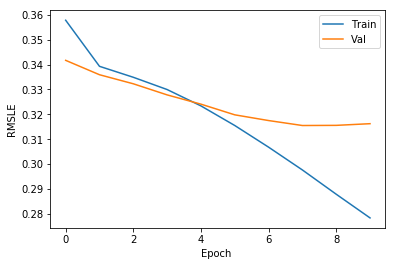

In [133]:
plt.plot(hist.history['loss'], label = 'Train');
plt.plot(hist.history['val_loss'], label ='Val');
plt.legend();
plt.xlabel('Epoch ');
plt.ylabel('RMSLE');

##### safe model

In [74]:
model.save('lstm_2l_32151.h5') 

##### load model

In [ ]:
from keras.models import load_model
#model = load_model('lstm_2l_32151.h5')

### 3. Embeddings visualization

In [ ]:
from sklearn.manifold import TSNE
from matplotlib import pylab

In [75]:
embeddings = model.layers[0].get_weights()[0]

In [77]:
embeddings.shape

(97, 50)

In [138]:
tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=30000)
two_d_embeddings = tsne.fit_transform(embeddings)

In [139]:
two_d_embeddings.shape

(97, 2)

In [140]:
word_index = tokenizer.word_index

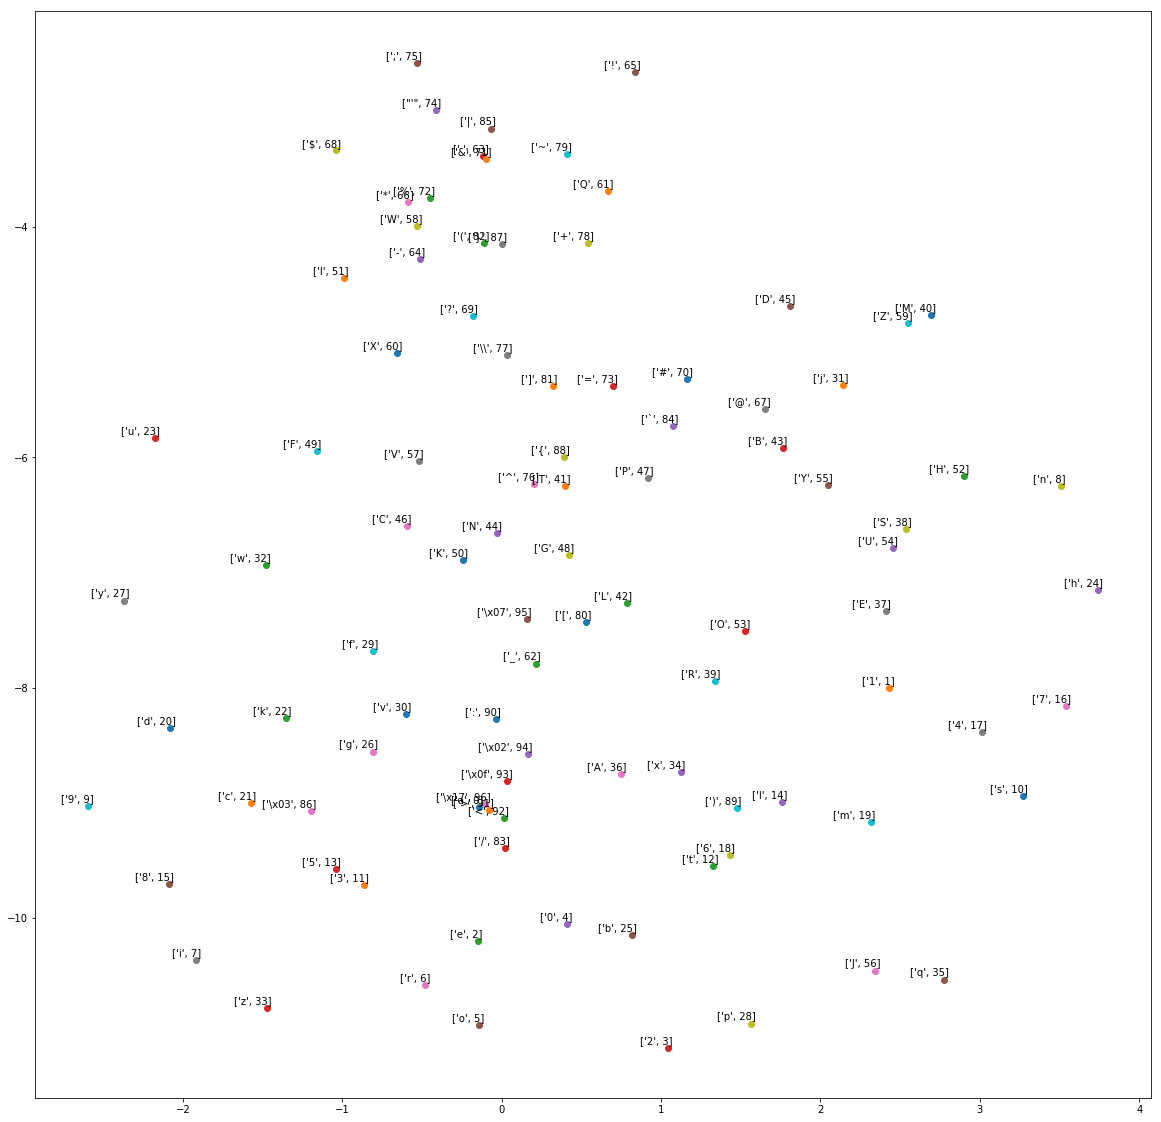

In [141]:
pylab.figure(figsize=(20,20))
for i, emb in zip(range(dict_len), two_d_embeddings):
    label = labels = list(word_index.keys())[i]
    x,y = emb   
    pylab.scatter(x, y)
    pylab.annotate([label,i], xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
pylab.show()

### 4. Predict for test part

In [68]:
y_pred = model.predict(X_test, batch_size=1024)

In [ ]:
submission = pd.read_csv('sample_submission.csv', index_col='Id');
submission.Times = y_pred;
submission.Times[res_sub.Times<1]=1

In [ ]:
submission.to_csv('res.csv')